In [1]:
from tqdm import tqdm
import pandas as pd
from sigmulib import compute_sigmul_cpp, compute_sigmul_cython
import numpy as np

from utils import *

torch.manual_seed(29)

Rajouter une partie 0 où l'on visualise l'effet de la parallélisation. (include_sequential)

In [4]:
dims = [2**i for i in range(10)]
all_times = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_torch', 'sigmul_sequential'])
diffs = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_sequential'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10)
    for key in times.keys():
        all_times.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs.loc[dim, 'sigmul_cpp'] = torch.abs(Bt - torch.tensor(compute_sigmul_cpp(A.tolist()))).sum().item() / (dim**2)
    diffs.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)
    diffs.loc[dim, 'sigmul_sequential'] = torch.abs(Bt - torch.tensor(unparallel_sigmul(A))).sum().item() / (dim**2)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:18<00:00, 13.84s/it]


Mettre les deux graphiques sur une même figure

<Axes: >

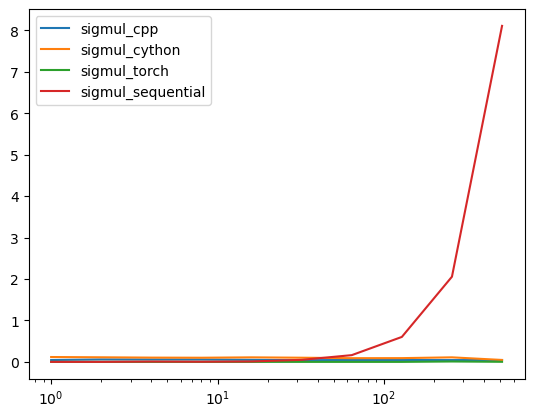

In [5]:
all_times.plot(logx=True)

<Axes: >

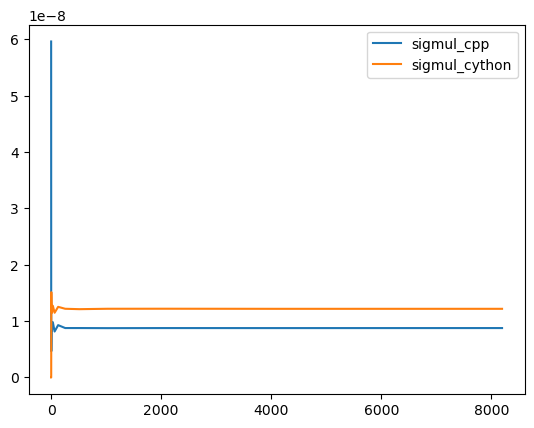

In [13]:
diffs.plot()

Conclusion : la méthode 'full cython' marche beaucoup mieux que celle basée sur C++, dont les temps de calculs explosent. On retient donc seulement la version Cython, et on essaie d'aller plus loin dans la comparaison avec torch.

In [2]:
dims = [2**i for i in range(18)]
all_times = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_torch'])
diffs = pd.DataFrame(index=dims, columns=['sigmul_cython'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10, include_cpp=False)
    for key in times.keys():
        all_times.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)


100%|██████████| 16/16 [00:50<00:00,  3.18s/it]


<Axes: >

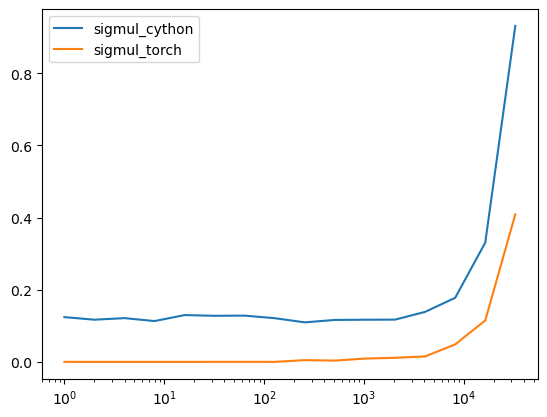

In [13]:
all_times.plot(logx=True)

In [6]:
all_times['ratio'] = all_times['sigmul_cython'] / all_times['sigmul_torch']

<Axes: >

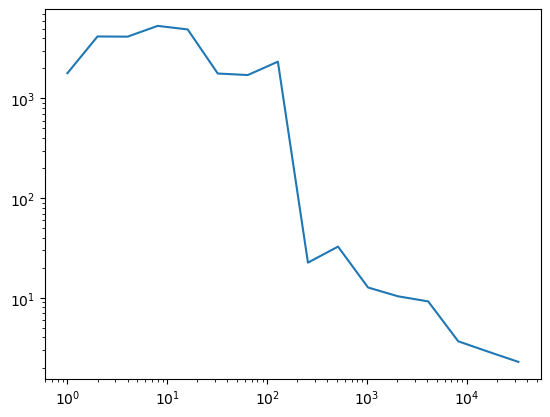

In [11]:
all_times['ratio'].plot(logx=True, logy=True)

<Axes: >

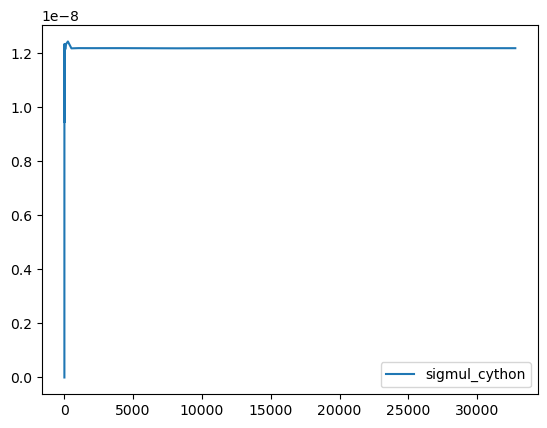

In [8]:
diffs.plot()

Conclusion : le ratio diminue fortement, les erreurs restent faibles. Cependant, on a omis le coût de conversion tensor->np.array, non négligeable avec des grands arrays, et nécessaire si l'on veut réellement inclure la fonction dans le modèle.

In [2]:
dims = [2**i for i in range(11)]
all_times = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_cython_with_conv', 'sigmul_torch'])
diffs = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_cython_with_conv'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=20, include_cpp=False, include_conv_cython=True)
    for key in times.keys():
        all_times.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)
    diffs.loc[dim, 'sigmul_cython_with_conv'] = torch.abs(Bt - sigmul_from_tensor_cython(A)).sum().item() / (dim**2)


100%|██████████| 11/11 [01:00<00:00,  5.50s/it]


In [3]:
all_times

,sigmul_cython,sigmul_cython_with_conv,sigmul_torch
1,0.110172,0.112704,0.000033
2,0.129116,0.106127,0.000037
4,0.129484,0.131065,0.000024
8,0.129249,0.125164,0.000026
16,0.124041,0.126314,0.000035
32,0.129469,0.128835,0.000031
64,0.126248,0.129124,0.000039
128,0.125066,0.130378,0.000049
256,0.125531,0.160036,0.004168
512,0.133553,0.156858,0.005127


<Axes: >

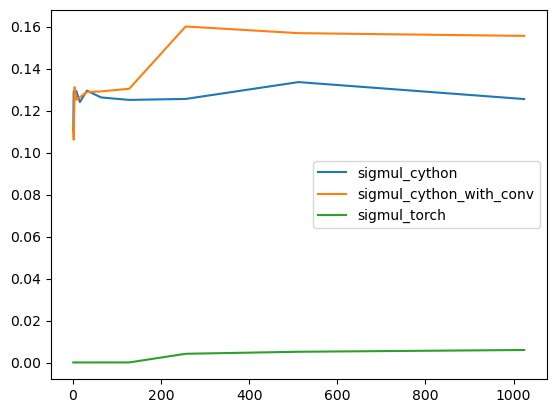

In [4]:
all_times.plot()